In [45]:
import keras
import pandas as pd
import tensorflow as tf

import numpy as np
# from keras.models import Sequential, Model
# from keras.layers import Dense, Dropout, Activation, Flatten, Convolution2D, MaxPooling2D, GlobalAveragePooling2D
from keras.utils import np_utils

from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, Convolution2D, MaxPooling2D, GlobalAveragePooling2D, Input,AveragePooling2D, BatchNormalization, LeakyReLU

# from keras.applications import MobileNet
# from keras.optimizers import Adam
from tensorflow.keras.applications import MobileNetV2, InceptionV3
from tensorflow.keras.optimizers import Adam

from matplotlib import pyplot as plt
import os
from sklearn.model_selection import train_test_split

import seaborn as sns
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.model_selection import KFold

from collections import defaultdict,Counter
from imblearn.over_sampling import SMOTE
from PIL import Image

from kerastuner import HyperModel

In [46]:
def getSpeciesCode(x):
    part = x.split('_')
    if part[0] == 'ASETRI':
        return 0
    elif part[0] == 'EPTBOT':
        return 1
    elif part[0] == 'MYOEMA':
        return 2
    elif part[0] == 'PIPKUH':
        return 3
    elif part[0] == 'RHIMUS':
        return 4
    elif part[0] == 'RHYNAS':
        return 5
    elif part[0] == 'ROUAEG':
        return 6
    elif part[0] == 'TAPPER':
        return 7
    else:
        return 'Unknown'
    
def getSpecies(x):
    if x == 0:
        return 'A.tridens'
    elif x == 1:
        return 'E.bottae'
    elif x == 2:
        return 'M.emarginatus'
    elif x == 3:
        return 'P.kuhli'
    elif x == 4:
        return 'R.muscatellum'
    elif x == 5:
        return 'R.nasutus'
    elif x == 6:
        return 'R.aegyptius'
    elif x == 7:
        return 'T.perforatus'
    else:
        return 'Unknown'
    

def generate_actual_predicted(Y_pred, Y_test): 
    predicted = list()
    for i in range(len(Y_pred)):
        predicted.append(np.argmax(Y_pred[i]))
        
    actual = list()
    for i in range(len(Y_test)):
        actual.append(np.argmax(Y_test[i]))
        
    return actual, predicted
    

In [47]:
# loading a test image
import os
from PIL import Image

X_all = []
Y_all = []

image_folder_path = '../data/SpectogramInitial'
file_paths = [f for f in os.listdir(image_folder_path)]

for file_name in file_paths:
    spectrogram = Image.open(image_folder_path + '/' + file_name)
    spectrogram = spectrogram.convert('RGB')
    spectrogram = spectrogram.resize((170, 112))  
    spectrogram = np.array(spectrogram)
    #spectrogram = np.expand_dims(spectrogram, axis=2) 
    X_all.append(spectrogram)
    Y_all.append(getSpeciesCode(file_name))
    

    
X_all = np.array(X_all)
Y_all = np.array(Y_all)




X_all = X_all.astype('float32')
X_all /= 255

Y_all = np_utils.to_categorical(Y_all, num_classes=8) 


print(X_all.shape)
print(Y_all.shape)

(3018, 112, 170, 3)
(3018, 8)


In [48]:
from sklearn.model_selection import StratifiedKFold

target_iter = 1
curr_iter = 1

X_test = []
Y_test = []

y_all_labelled=[]
for i in range(len(Y_all)):
        y_all_labelled.append(np.argmax(Y_all[i]))
for train_index,test_index in StratifiedKFold(10, shuffle=True, random_state=123).split(X_all,y_all_labelled):  
    # use the index to generate training an testing sets
    _,X_test=X_all[train_index],X_all[test_index]
    _,Y_test=Y_all[train_index],Y_all[test_index]
    if target_iter == curr_iter:
        break
        

In [50]:
import numpy as np
import tensorflow as tf

# Load the TFLite model and allocate tensors.
interpreter = tf.lite.Interpreter(model_path="mel_smote_v1_iter_1.tflite")
interpreter.resize_tensor_input(0, X_test.shape)
interpreter.allocate_tensors()

# Get input and output tensors.
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()
print(input_details)
print(output_details)

[{'name': 'input_2', 'index': 0, 'shape': array([302, 112, 170,   3], dtype=int32), 'dtype': <class 'numpy.float32'>, 'quantization': (0.0, 0)}]
[{'name': 'Identity', 'index': 25, 'shape': array([302,   8], dtype=int32), 'dtype': <class 'numpy.float32'>, 'quantization': (0.0, 0)}]


In [51]:
# Test the model on random input data.
input_data = X_test
interpreter.set_tensor(input_details[0]['index'], input_data)

interpreter.invoke()

# The function `get_tensor()` returns a copy of the tensor data.
# Use `tensor()` in order to get a pointer to the tensor.
output_data = interpreter.get_tensor(output_details[0]['index'])
print(output_data)

[[1.3842889e-09 1.3211725e-05 3.2768057e-06 ... 7.0694443e-07
  1.1069074e-07 8.7909024e-07]
 [1.4143287e-11 2.1690190e-11 3.3665382e-10 ... 4.8199156e-10
  1.0131199e-08 3.5374697e-09]
 [3.0655818e-11 8.2686222e-09 7.3822356e-08 ... 9.9999988e-01
  2.0201232e-09 2.5469913e-09]
 ...
 [9.2397523e-10 1.2487891e-06 7.8590531e-08 ... 3.7791077e-09
  1.5232855e-08 4.0783607e-07]
 [1.0721586e-08 7.2087573e-08 4.6616336e-05 ... 1.2600331e-06
  7.8795779e-08 9.9993980e-01]
 [7.4865705e-13 9.5361095e-15 4.6675340e-15 ... 4.9235165e-12
  1.3036599e-11 1.1224793e-08]]


In [52]:
output_data.shape

(302, 8)

In [53]:
from sklearn.metrics import precision_recall_fscore_support
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve, auc, precision_recall_curve
from sklearn.metrics import confusion_matrix
n_classes=8
    
#generate predictions
actual, predicted = generate_actual_predicted(output_data, Y_test)

#calc metrics
curr_base_prec, curr_base_rec, curr_f1, _ = precision_recall_fscore_support(actual, predicted)
curr_macro_prec = precision_score(actual, predicted,average='macro')
curr_macro_rec = recall_score(actual, predicted,average='macro')
curr_macro_f1 = f1_score(actual, predicted,average='macro')

actual_labeled = list()
predict_labeled = list()
for x,y in zip(actual,predicted):
    actual_labeled.append(getSpecies(x))
    predict_labeled.append(getSpecies(y))

labels = ['A.tridens','E.bottae','M.emarginatus','P.kuhli','R.muscatellum','R.nasutus', 'R.aegyptius', 'T.perforatus','No_Bat']
curr_cm=confusion_matrix(actual_labeled,predict_labeled,labels=labels)

curr_fpr = [0] * n_classes
curr_tpr = [0] * n_classes
for i in range(n_classes):
    curr_fpr[i], curr_tpr[i], _ = roc_curve(Y_test[:,i], output_data[:,i])

curr_prec = [0] * n_classes
curr_rec = [0] * n_classes
for i in range(n_classes):
    curr_prec[i], curr_rec[i], _ = precision_recall_curve(Y_test[:,i], output_data[:,i])


curr_accuracy = accuracy_score(actual, predicted)

    
    

In [54]:
print('precision by class', curr_base_prec)

print('macro precision',curr_macro_prec)

print('recall by class', curr_base_rec)

print('macro recall', curr_macro_rec)

print('f1 by class', curr_f1)

print('macro f1', curr_macro_f1)

print('accuracy', curr_accuracy)


precision by class [1.         0.92857143 0.90909091 0.96551724 0.98192771 1.
 1.         0.95121951]
macro precision 0.9670408502600178
recall by class [1.         1.         0.90909091 0.96551724 0.98192771 0.96296296
 1.         0.95121951]
macro recall 0.9713397920589597
f1 by class [1.         0.96296296 0.90909091 0.96551724 0.98192771 0.98113208
 1.         0.95121951]
macro f1 0.968981301492922
accuracy 0.9735099337748344


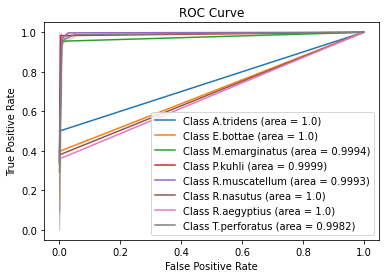

In [55]:
_, axs = plt.subplots(ncols=1)
axs.set(xlabel='False Positive Rate',ylabel='True Positive Rate', title='ROC Curve')
for j in range(n_classes):
    auc_val = auc(curr_fpr[j], curr_tpr[j])
    auc_val = np.around(auc_val,4)
    sns.lineplot(x=curr_fpr[j],y=curr_tpr[j],ax=axs, label='Class '+ getSpecies(j) +' (area = ' + str(auc_val) + ')', legend='brief')


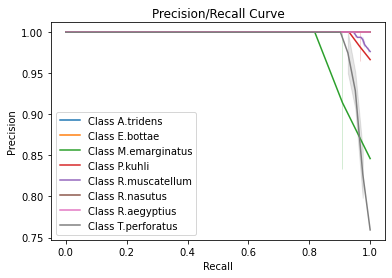

In [56]:
_, axs = plt.subplots(ncols=1)
axs.set(xlabel='Recall',ylabel='Precision', title='Precision/Recall Curve')
for j in range(n_classes):
    sns.lineplot(x=curr_rec[j],y=curr_prec[j],ax=axs, label='Class '+ getSpecies(j), legend='brief')

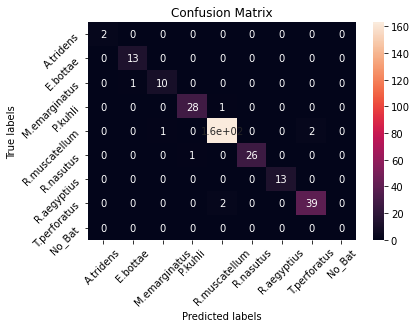

In [57]:
import numpy as np
import matplotlib.pylab as pl
import matplotlib.gridspec as gridspec
from matplotlib import pyplot as plt

_, ax = plt.subplots(ncols=1)

sns.heatmap(curr_cm, annot=True); #annot=True to annotate cells


# labels, title and ticks
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels(labels,rotation=45); ax.yaxis.set_ticklabels(labels,rotation=45);

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


In [2]:
cm = [
    [2,0,0,0,0,0,0,0],
    [0,13,0,0,0,0,0,0],
    [0,1,10,0,0,0,0,0],
    [0,0,0,28,1,0,0,0],
    [0,0,1,0,160,0,0,0],
    [0,0,0,1,0,26,0,0],
    [0,0,0,0,0,0,13,0],
    [0,0,0,0,2,0,0,39],
     ]
cm = np.array(cm)

[[1.   0.   0.   0.   0.   0.   0.   0.  ]
 [0.   1.   0.   0.   0.   0.   0.   0.  ]
 [0.   0.09 0.91 0.   0.   0.   0.   0.  ]
 [0.   0.   0.   0.97 0.03 0.   0.   0.  ]
 [0.   0.   0.01 0.   0.99 0.   0.   0.  ]
 [0.   0.   0.   0.04 0.   0.96 0.   0.  ]
 [0.   0.   0.   0.   0.   0.   1.   0.  ]
 [0.   0.   0.   0.   0.05 0.   0.   0.95]]


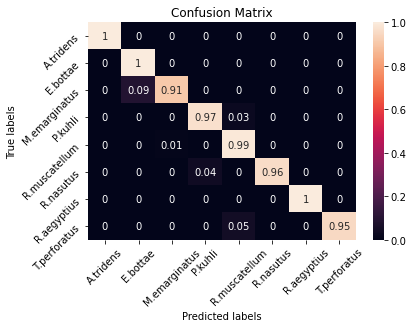

In [4]:
cm= cm/ cm.astype(np.float).sum(axis=1,keepdims = True)



cm = (np.around(cm,2))
print(cm)


labels = ['A.tridens','E.bottae','M.emarginatus','P.kuhli','R.muscatellum','R.nasutus', 'R.aegyptius', 'T.perforatus']


ax= plt.subplot()
sns.heatmap(cm, annot=True, ax = ax); #annot=True to annotate cells

# labels, title and ticks
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels(labels,rotation=45); ax.yaxis.set_ticklabels(labels,rotation=45);

In [ ]:
##